# Quantum Phase Estimation for a Matrix

This notebook demonstrates the capability of Classiq's Synthesis engine to reduce depth and cx-counts when modeling a Quantum Phase Estimation (QPE) on a unitary that is hard-coded unitary matrix (of the form $e^{2\pi i A}$, with $A$ Hermitian).

In [1]:
import numpy as np
import scipy

# taking a random example, rescaling and shifting the matrix to guarantee eigenvalues in [0,1)
np.random.seed(1235)
new_mat = np.random.rand(8, 8)
new_mat = (new_mat + new_mat.T) / 2

w, v = np.linalg.eig(new_mat)
w_max = np.max(np.abs(w))

mew_mat = (new_mat + w_max) / (2 * w_max)

my_unitary = scipy.linalg.expm(1j * 2 * np.pi * new_mat)

precisions = [l for l in range(1, 9)]
print("precisions:", precisions)

precisions: [1, 2, 3, 4, 5, 6, 7, 8]


In [2]:
transpilation_options = {"classiq": "custom", "qiskit": 3}

## 1. Classiq's QPE

In [3]:
from classiq import (
    QArray,
    QNum,
    QuantumProgram,
    allocate,
    allocate_num,
    create_model,
    qfunc,
    qpe,
    set_preferences,
    show,
    synthesize,
    unitary,
)
from classiq.model import CustomHardwareSettings, Preferences

classiq_depths = []
classiq_cx_counts = []

preferences = Preferences(
    custom_hardware_settings=CustomHardwareSettings(basis_gates=["cx", "u"]),
    transpilation_option=transpilation_options["classiq"],
)

for precision in precisions:

    @qfunc
    def main():
        phase = QNum("phase")
        state = QArray("state")
        allocate(3, state)
        allocate_num(precision, False, precision, phase)
        qpe(
            unitary=lambda: unitary(elements=my_unitary.tolist(), target=state),
            phase=phase,
        )

    qmod = create_model(main)
    qmod = set_preferences(qmod, preferences=preferences)
    qprog = synthesize(qmod)
    circuit = QuantumProgram.from_qprog(qprog)
    depth_classiq = circuit.transpiled_circuit.depth
    classiq_depths.append(depth_classiq)
    classiq_cx_counts.append(circuit.transpiled_circuit.count_ops["cx"])

print("classiq depths:", classiq_depths)
print("classiq cx-counts:", classiq_cx_counts)

classiq depths: [180, 363, 546, 731, 916, 1101, 1286, 1471]
classiq cx-counts: [96, 195, 294, 396, 500, 606, 714, 824]


## 2. Comparing to Qiskit Implementations

The qiskit data was generated using qiskit version 1.0.0. To run the qiskit code uncomment the commented cells below.

In [4]:
qiskit_depths = [320, 950, 2206, 4706, 9694, 19658, 39574, 79394]
qiskit_cx_counts = [162, 484, 1124, 2398, 4938, 10008, 20136, 40378]

In [5]:
# from importlib.metadata import version
# try:
#     import qiskit
#     if version('qiskit') != "1.0.0":
#       !pip uninstall qiskit -y
#       !pip install qiskit==1.0.0
# except ImportError:
#     !pip install qiskit==1.0.0

In [6]:
# from qiskit import QuantumCircuit, QuantumRegister, transpile
# from qiskit.circuit.library import PhaseEstimation

# q = QuantumRegister(3, "q")
# qc = QuantumCircuit(q)
# qc.unitary(my_unitary.tolist(), q)

# qiskit_depths = []
# qiskit_cx_counts = []
# for precision in precisions:
#     qpe_qc = PhaseEstimation(precision, qc)
#     transpiled_cir = transpile(
#         qpe_qc,
#         basis_gates=["u", "cx"],
#         optimization_level=transpilation_options["qiskit"],
#     )
#     qiskit_depths.append(transpiled_cir.depth())
#     qiskit_cx_counts.append(transpiled_cir.count_ops()["cx"])

# print("qiskit depths:", qiskit_depths)
# print("qiskit cx-counts:", qiskit_cx_counts)

## 3. Plotting the Data 

Text(0.9, 65000.0, '(a)')

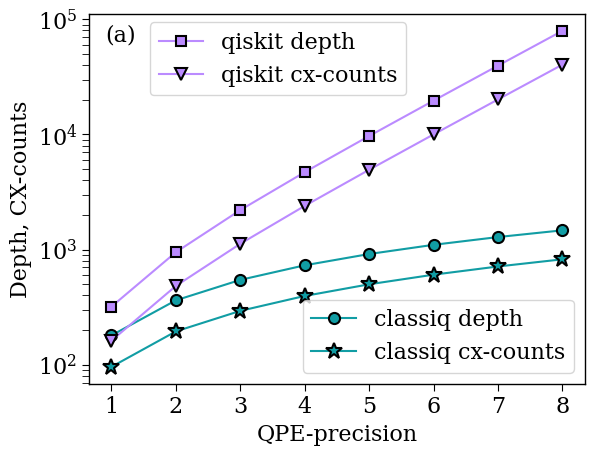

In [7]:
import matplotlib.pyplot as plt

classiq_color = "#119DA4"
qiskit_color = "#bb8bff"
plt.rcParams["font.family"] = "serif"
plt.rc("savefig", dpi=300)
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5

plt.rcParams["axes.linewidth"] = 1
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.minor.size"] = 5
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.minor.size"] = 5


(classiq1,) = plt.semilogy(
    precisions,
    classiq_depths,
    "-o",
    label="classiq depth",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(classiq2,) = plt.semilogy(
    precisions,
    classiq_cx_counts,
    "-*",
    label="classiq cx-counts",
    markerfacecolor=classiq_color,
    markeredgecolor="k",
    markersize=12,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=classiq_color,
)
(qiskit1,) = plt.semilogy(
    precisions,
    qiskit_depths,
    "-s",
    label="qiskit depth",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=7,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)
(qiskit2,) = plt.semilogy(
    precisions,
    qiskit_cx_counts,
    "-v",
    label="qiskit cx-counts",
    markerfacecolor=qiskit_color,
    markeredgecolor="k",
    markersize=8,
    markeredgewidth=1.5,
    linewidth=1.5,
    color=qiskit_color,
)

first_legend = plt.legend(
    handles=[qiskit1, qiskit2],
    fontsize=16,
    loc="lower left",
    bbox_to_anchor=(0.1, 0.75),
)
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[classiq1, classiq2], fontsize=16, loc="lower right")

plt.ylabel("Depth, CX-counts", fontsize=16)
plt.xlabel("QPE-precision", fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.text(0.9, 0.65e5, "(a)", fontsize=16)